In [277]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [273]:
df_test0 = pd.read_feather('../data/test_train_split/test_0.feather')
df_test1 = pd.read_feather('../data/test_train_split/test_1.feather')
df_test2 = pd.read_feather('../data/test_train_split/test_2.feather')
df_test3 = pd.read_feather('../data/test_train_split/test_3.feather')
df_test_combined = pd.concat([df_test0, df_test1, df_test2, df_test3], ignore_index=True)

df_train0 = pd.read_feather('../data/test_train_split/train_0.feather')
df_train1 = pd.read_feather('../data/test_train_split/train_1.feather')
df_train2 = pd.read_feather('../data/test_train_split/train_2.feather')
df_train3 = pd.read_feather('../data/test_train_split/train_3.feather')
df_train_combined = pd.concat([df_train0, df_train1, df_train2, df_train3], ignore_index=True)

df = pd.read_feather('../data/clean/CleanedData.feather')

Best alpha value: 10000.0
Root Mean Squared Error (RMSE): 0.8182508758133379
Mean Squared Error: 0.6695344957692945
R-squared: 0.7265788649496221
MAPE: 7.6%


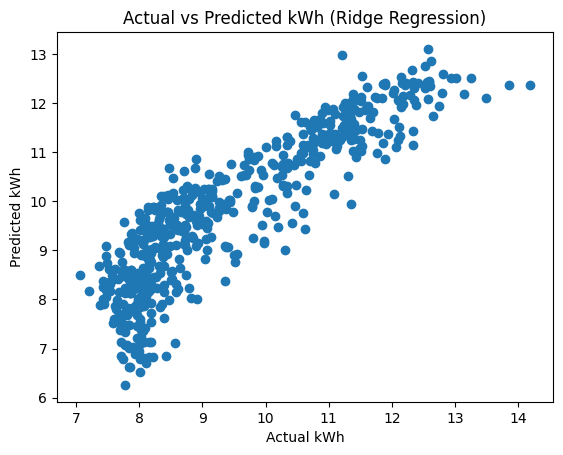

In [346]:
X = df.drop(['avgKWH', 'Date', 'volume weighted price', 'max_temp', 'min_temp', 'days_elapsed', 'weekday sin', 'weekday cos', 'month sin', 'month cos', 'Time of Year sin', 'Time of Year cos'], axis=1)
y = df['avgKWH']

X_train = df_train_combined.drop(['avgKWH', 'Date', 'volume weighted price', 'max_temp', 'min_temp', 'days_elapsed', 'weekday sin', 'weekday cos', 'month sin', 'month cos', 'Time of Year sin', 'Time of Year cos'], axis=1)  # Features 
y_train = df_train_combined['avgKWH']  # Target variable

X_test = df_test_combined.drop(['avgKWH', 'Date', 'volume weighted price', 'max_temp', 'min_temp', 'days_elapsed', 'weekday sin', 'weekday cos', 'month sin', 'month cos', 'Time of Year sin', 'Time of Year cos'], axis=1)  # Features 
y_test = df_test_combined['avgKWH']  # Target variable

# Get the best alpha
alpha_values = np.logspace(-6, 6, 13)
param_grid = {'alpha': alpha_values}
ridge = Ridge(positive=True)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha value: {best_alpha}")


# Build a Ridge Regression model
alpha = best_alpha
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print("MAPE: {:.1%}".format(mape))

# Plot actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual kWh')
plt.ylabel('Predicted kWh')
plt.title('Actual vs Predicted kWh (Ridge Regression)')
plt.show()

In [347]:
#Forecasting with shifting approach
future_data = df.drop(['volume weighted price', 'max_temp', 'min_temp', 'days_elapsed', 'weekday sin', 'weekday cos', 'month sin', 'month cos', 'Time of Year sin', 'Time of Year cos'], axis=1)

future_data['Date_shift'] = future_data['Date'].shift(1)
future_data['cloud_cover_shift'] = future_data['cloud_cover'].shift(1)
future_data['sunshine_shift'] = future_data['sunshine'].shift(1)
future_data['global_radiation_shift'] = future_data['global_radiation'].shift(1)
future_data['mean_temp_shift'] = future_data['mean_temp'].shift(1)
future_data['precipitation_shift'] = future_data['precipitation'].shift(1)
future_data['pressure_shift'] = future_data['pressure'].shift(1)
future_data['snow_depth_shift'] = future_data['snow_depth'].shift(1)
future_data['year_shift'] = future_data['year'].shift(1)
#future_data['avgKWH_shift'] = future_data['avgKWH'].shift(1)

future_data =future_data.drop(['Date', 'cloud_cover', 'sunshine', 'global_radiation', 'mean_temp', 'precipitation', 'pressure', 'snow_depth', 'year'], axis=1)

future_data.rename(columns={"Date_shift": "Date", 
                            "cloud_cover_shift": "cloud_cover",
                            "sunshine_shift": "sunshine",
                            "global_radiation_shift": "global_radiation",
                            "mean_temp_shift": "mean_temp",
                            "precipitation_shift": "precipitation",
                            "pressure_shift": "pressure",
                            "snow_depth_shift": "snow_depth",
                            "year_shift": "year"
                           }, inplace=True)

future_data = future_data.dropna()

shifted_features = ['cloud_cover', 'sunshine', 'global_radiation', 'mean_temp', 'precipitation', 'pressure', 'snow_depth', 'year']
future_predictions = ridge_model.predict(future_data[shifted_features])


Root Mean Squared Error (RMSE): 0.9665869374914173
Mean Squared Error: 0.9342903077290372
R-squared: 0.7049173201207622
MAPE: 10.7%


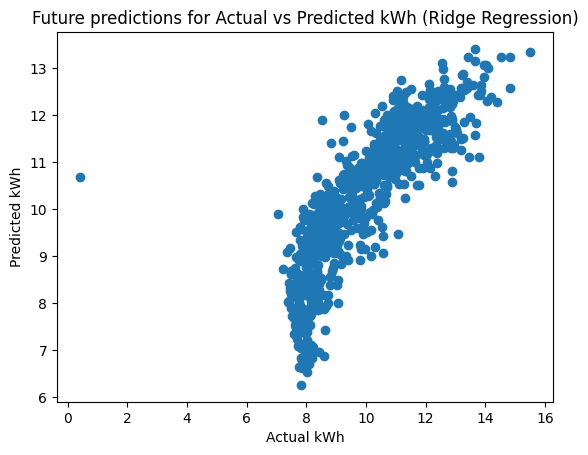

In [348]:
# Evaluate the model
mse = mean_squared_error(future_data['avgKWH'], future_predictions)
r2 = r2_score(future_data['avgKWH'], future_predictions)
rmse = np.sqrt(mean_squared_error(future_data['avgKWH'], future_predictions))
mape = mean_absolute_percentage_error(future_data['avgKWH'], future_predictions)

print(f'Root Mean Squared Error (RMSE): {rmse}')

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print("MAPE: {:.1%}".format(mape))

# Plot actual vs predicted values
plt.scatter(future_data['avgKWH'], future_predictions)
plt.xlabel('Actual kWh')
plt.ylabel('Predicted kWh')
plt.title('Future predictions for Actual vs Predicted kWh (Ridge Regression)')
plt.show()

20:17:53 - cmdstanpy - INFO - Chain [1] start processing
20:17:53 - cmdstanpy - INFO - Chain [1] done processing


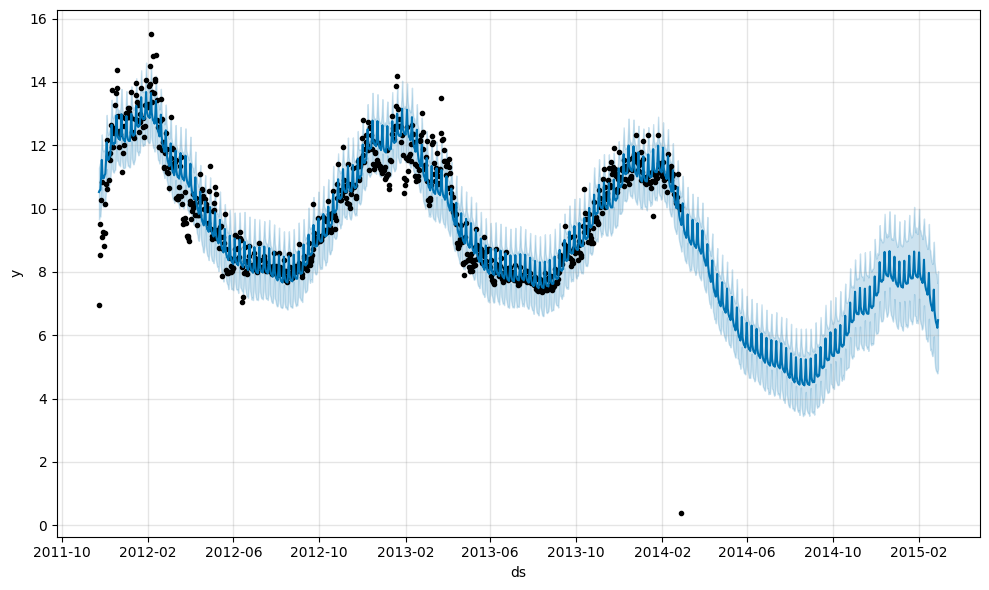

In [345]:
#Using Prophet as another approach for forecasting 
model = Prophet()
prophet_data = df.rename(columns={'Date': 'ds', 'avgKWH': 'y'})
model.fit(prophet_data)

# Create a DataFrame with future dates for prediction
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)